In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trekc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Скачиваем данные

In [2]:
#!python -m wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

In [2]:
import pandas as pd
data = pd.read_csv('answers_subsample.csv')
data

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон
...,...,...
237774,relax,елку нарядили? =)
237775,law,"Имеется переработка при 75% ставки, отгулы не ..."
237776,food,Попробовала варить рис с половиной кубика для ...
237777,food,Почему рекоменд... Почему рекомендуют есть фру...


In [3]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [6]:
#!python -m wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

In [4]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [5]:
# потом можете добавить свою предобработку

def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [6]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████████████████████████████████████████████████████████████████| 237779/237779 [00:02<00:00, 111944.07it/s]


In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

C:\Users\trekc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

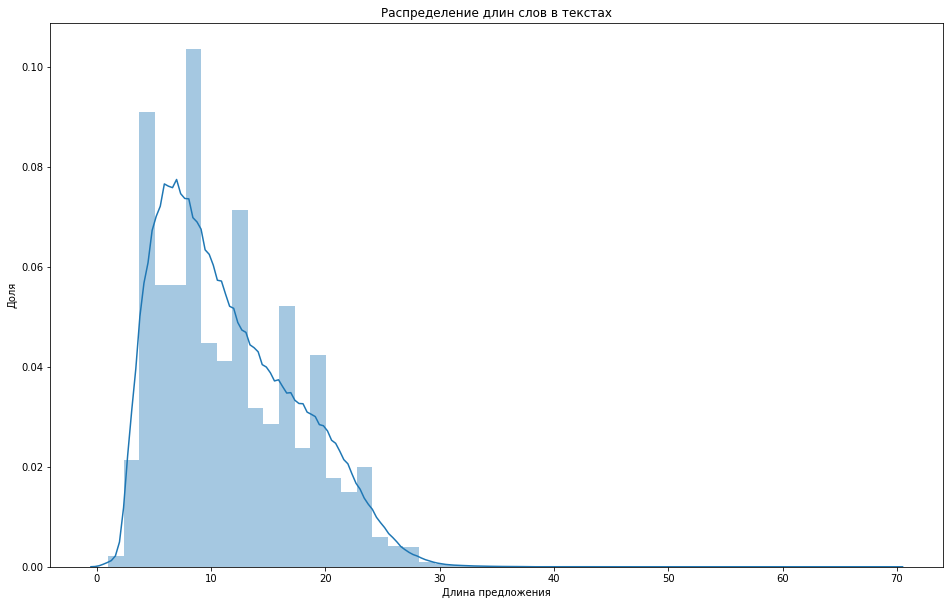

In [8]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [9]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'99.66 % наших текстов входят в промежуток от 3 до 32 слов'

In [10]:
len(word2freq)

152179

In [11]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'114332 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [12]:
import numpy as np

In [13]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec', encoding='utf-8')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])
    
    if current_word in word2freq:

        word2index[current_word] = len(word2index)
        current_vectors = current_parts[-embedding_dim:]

        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)
    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████████████████████████████████████████████████| 2000000/2000000 [00:59<00:00, 33625.54it/s]


In [14]:
len(word2index)

117619

In [15]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 2.50 % слов в датасете
Количество неизвестных слов 34561 из 152179, то есть 22.71 % уникальных слов в словаре
В среднем каждое встречается 1.98 раз

Топ 5 невошедших слов:
??? с количеством вхождениий - 3641
?? с количеством вхождениий - 2448
!!! с количеством вхождениий - 2214
?) с количеством вхождениий - 2069
"? с количеством вхождениий - 1429


# Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [ ]:
# # первый способ
# lstm = torch.nn.LSTM(1024, 512, batch_first=True)

# pred, mem = lstm(x)

In [ ]:
# pred.shape

In [ ]:
# lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
# x_transposed = x.transpose(0, 1)
# pred_transposed, mem = lstm(x_transposed)

In [ ]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
# pred_transposed.shape

In [ ]:
# просто транспонируем еще раз
# pred = pred_transposed.transpose(0, 1)
# pred.shape

## Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [ ]:
# x.shape

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [ ]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
# cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [ ]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [ ]:
# x_transposed = x.transpose(1, 2)
# x_transposed.shape
# перевели в (batch, input_size, seq_len)

In [ ]:
# pred_transposed = cnn(x_transposed)
# pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

In [ ]:
# переведем обратно в (batch, seq_len, input_size)
# pred = pred_transposed.transpose(1, 2)
# pred.shape

# Подготовим данные в DataLoader

In [16]:
from torch.utils.data import Dataset, DataLoader

In [17]:
'UNK' in word2index

False

In [18]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


# Замапим категории в индексы

In [19]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [20]:
cat_mapper

{'business': 0, 'law': 1, 'love': 2, 'relax': 3, 'food': 4}

In [21]:
data.category = data.category.map(cat_mapper)

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
    1. Паддим до нужной длины
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.


In [22]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        
        # Место для вашей предобработки
        
        words = wordpunct_tokenize(text.lower())
        #words = re.findall('[a-яА-ЯеЁ]+', text.lower())
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
            add_pad = self.sequence_length - len(sequence)
            return sequence+[self.pad_index]*add_pad
        else:
            return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [24]:
x_train, x_validation, y_train, y_validation = train_test_split(data.text, data.category, test_size=0.1)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data: 100%|██████████████████████████████████████████████████████████| 23778/23778 [00:00<00:00, 103203.19it/s]


In [25]:
import torch

for x, y in train_loader:
    break

In [26]:
x

tensor([[13208, 10280,   227,  ...,     0,     0,     0],
        [ 2285,     8, 21589,  ...,     0,     0,     0],
        [  710,  4339, 10746,  ...,     0,     0,     0],
        ...,
        [10015,  1882,     1,  ...,     0,     0,     0],
        [ 6811,     1,    26,  ...,     0,     0,     0],
        [  185,    21, 24775,  ...,     0,     0,     0]])

In [27]:
y

tensor([2, 3, 3, 3, 4, 1, 1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 3, 3, 0, 0, 1, 4, 0, 1,
        3, 0, 0, 0, 1, 4, 4, 2, 4, 2, 4, 2, 1, 3, 3, 4, 2, 4, 0, 1, 1, 1, 2, 3,
        0, 0, 1, 4, 4, 1, 0, 3, 1, 3, 4, 4, 0, 1, 2, 3])

# Обучить нейронку

In [28]:
from math import sqrt
from torch import nn


class model_with_att(torch.nn.Module):
    def __init__(self, matrix_w, n, lstm_size, tripple_linear_size, cnn_outsize, inner_linear_size): #n - количетсво категорий

        super().__init__()

        self.n = n

        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

        self.LSTM = lstm = nn.LSTM(input_size=matrix_w.shape[1], hidden_size=lstm_size,
                          num_layers=2, dropout=0.1, bidirectional=True, batch_first=True)
        
        # три линейных преобразования, размерность совпадает с выходом из лстм (если БИлстм то надо умножить ее на 2)
        self.q_proj = nn.Linear(lstm_size*2, tripple_linear_size)
        self.k_proj = nn.Linear(lstm_size*2, tripple_linear_size)
        self.v_proj = nn.Linear(lstm_size*2, tripple_linear_size)

        self.att_soft = torch.nn.Softmax(dim = 2)
        
        # три конволюционных фильтра с разными ядрами (3,4,5) чтобы были всякие нграммы ловить
        self.cnn_3gr =  nn.Conv1d(in_channels=tripple_linear_size, out_channels=cnn_outsize, kernel_size=3)
        self.cnn_4gr = nn.Conv1d(in_channels=tripple_linear_size, out_channels=cnn_outsize, kernel_size=4)
        self.cnn_5gr = nn.Conv1d(in_channels=tripple_linear_size, out_channels=cnn_outsize, kernel_size=5)
        
        # сверху накидываем два полносвязных слоя для классификации
        self.linear_1 = nn.Linear(3*cnn_outsize, inner_linear_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(inner_linear_size, out_features=n) 

        
    def forward(self, x):
        #примените эмбеддинги
        x_emb = self.emb_layer(x)
        # транспонируйте тензор для лстм как было описано выше
        x_emb = x_emb.transpose(0, 1)
        
        x, _ = self.LSTM(x_emb) # применим лстм, не забываем что на выходе у него много всяких последовательностей, 
        #нам нужна только эта
        x = x.transpose(0, 1)
#         print(x.shape)
        # транспонируйте обратно

        x_q = self.q_proj(x) #применим линейные преобразования для селф-эттеншена
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)
#         print(x_v.shape)
        att_scores = torch.bmm(x_q, x_k.transpose(2, 1)) / sqrt(x_emb.shape[2])
#         print(att_scores.shape)
        # посмотрите в презентацию и перемножьте нужные тензора изспольуя функцию bmm из торча, 
        # перед этим одну из матриц обзательно транспонируйте
        # результат обязательно поделите на корень из последней размерности (то есть на рземер эмбеддинга из предыдущего слоя)
        att_dist = self.att_soft(att_scores) # накидываем софтмакс
        attention_vectors = torch.bmm(att_dist, x_v)
#         print(attention_vectors.shape)

        x_att = attention_vectors.transpose(2,1) #транспонируем для конфолючионнах фильтров

        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)
#         print(x_cnn3.shape)
#         print(x_cnn4.shape)
#         print(x_cnn5.shape)
        
        frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
        sc, _ = x_cnn4.max(dim= -1,)
        thr, _ = x_cnn5.max(dim= -1,)
#         print(frst.shape)
#         print(sc.shape)
#         print(thr.shape)
        x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты
        # пару полносвязных слоев с релу для классификации
#         print(x_cat.shape)

        x =  self.linear_1(x_cat)
        x = self.relu(x)    
        x = self.linear_2(x)

        return x

In [29]:
n_classes = data.category.unique().shape[0]
model = model_with_att(vectors, n_classes, lstm_size=128,
                      tripple_linear_size=128, cnn_outsize=60, inner_linear_size=60)
model

#model #если сделать batch_first=True, то можно не транспонировать батчи

with torch.no_grad():
    pred = model(x)

In [30]:
model = model_with_att(vectors, n_classes, lstm_size=256,
                      tripple_linear_size=256, cnn_outsize=128, inner_linear_size=256)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [45]:
def training_foo():
    epochs = 10
    losses = []
    best_test_loss = 10.

    test_f1 = []

    for n_epoch in range(epochs):

        train_losses = []
        test_losses = []
        test_targets = []
        test_pred_class = []

        progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        model.train()

        for x, y in train_loader:

            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            pred = model(x)
            loss = criterion(pred, y)

            loss.backward()

            optimizer.step()

            train_losses.append(loss.item())
            losses.append(loss.item())

            progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

        model.eval()

        for x, y in validation_loader:

            x = x.to(device)

            with torch.no_grad():

                pred = model(x)

                pred = pred.cpu()

                test_targets.append(y.numpy())
                test_pred_class.append(np.argmax(pred, axis=1))

                loss = criterion(pred, y)

                test_losses.append(loss.item())

        mean_test_loss = np.mean(test_losses)

        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        f1 = f1_score(test_targets, test_pred_class, average='micro')

        test_f1.append(f1)

        print()
        print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

        print('F1 test - {:.3f}'.format(f1))

        # Early stopping:
        if mean_test_loss < best_test_loss:
            best_test_loss = mean_test_loss
        else:
            print('Early stopping')
            break

In [46]:
torch.manual_seed(0)
training_foo()

Epoch 1: 100%|██████████████████████████████████████████████| 214001/214001 [01:37<00:00, 2194.45it/s, train_loss=0.49]



Losses: train - 0.618, test - 0.483
F1 test - 0.824


Epoch 2: 100%|█████████████████████████████████████████████| 214001/214001 [01:35<00:00, 2238.15it/s, train_loss=0.459]



Losses: train - 0.473, test - 0.456
F1 test - 0.835


Epoch 3: 100%|█████████████████████████████████████████████| 214001/214001 [01:35<00:00, 2229.46it/s, train_loss=0.439]



Losses: train - 0.449, test - 0.442
F1 test - 0.841


Epoch 4: 100%|██████████████████████████████████████████████| 214001/214001 [01:36<00:00, 2222.84it/s, train_loss=0.42]



Losses: train - 0.430, test - 0.439
F1 test - 0.841


Epoch 5: 100%|███████████████████████████████████████████████| 214001/214001 [01:36<00:00, 2228.16it/s, train_loss=0.4]



Losses: train - 0.411, test - 0.449
F1 test - 0.839
Early stopping


Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

In [31]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

# Оценка
1. Добрались сюда - очень хорошо - получилась такая же точность или около того - 7 баллов.
2. Поставили эксперименты и повысили точность относительно своей и не ниже F1 test - 0.841 - 8 баллов.
3. Запустили бертовую тетрадку и разобрались. Получился сравнимый результат - 10 баллов 

In [32]:
model = model_with_att(vectors, n_classes, lstm_size=10,
                      tripple_linear_size=64, cnn_outsize=32, inner_linear_size=32)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [48]:
training_foo()

Epoch 1: 100%|█████████████████████████████████████████████| 214001/214001 [00:54<00:00, 3957.15it/s, train_loss=0.567]



Losses: train - 0.817, test - 0.535
F1 test - 0.806


Epoch 2: 100%|█████████████████████████████████████████████| 214001/214001 [00:54<00:00, 3953.72it/s, train_loss=0.494]



Losses: train - 0.520, test - 0.481
F1 test - 0.825


Epoch 3: 100%|█████████████████████████████████████████████| 214001/214001 [00:54<00:00, 3937.57it/s, train_loss=0.471]



Losses: train - 0.484, test - 0.463
F1 test - 0.832


Epoch 4: 100%|█████████████████████████████████████████████| 214001/214001 [00:54<00:00, 3948.10it/s, train_loss=0.461]



Losses: train - 0.468, test - 0.454
F1 test - 0.837


Epoch 5: 100%|█████████████████████████████████████████████| 214001/214001 [00:54<00:00, 3954.85it/s, train_loss=0.452]



Losses: train - 0.459, test - 0.449
F1 test - 0.839


Epoch 6: 100%|█████████████████████████████████████████████| 214001/214001 [00:53<00:00, 4001.72it/s, train_loss=0.445]



Losses: train - 0.451, test - 0.444
F1 test - 0.840


Epoch 7: 100%|██████████████████████████████████████████████| 214001/214001 [00:53<00:00, 3972.69it/s, train_loss=0.44]



Losses: train - 0.445, test - 0.442
F1 test - 0.841


Epoch 8: 100%|█████████████████████████████████████████████| 214001/214001 [00:53<00:00, 3971.96it/s, train_loss=0.435]



Losses: train - 0.440, test - 0.440
F1 test - 0.842


Epoch 9: 100%|█████████████████████████████████████████████| 214001/214001 [00:51<00:00, 4193.29it/s, train_loss=0.431]



Losses: train - 0.436, test - 0.438
F1 test - 0.842


Epoch 10: 100%|████████████████████████████████████████████| 214001/214001 [00:50<00:00, 4231.71it/s, train_loss=0.427]



Losses: train - 0.431, test - 0.436
F1 test - 0.844


F1 test - 0.844 - улучшение получено! Из значимого я уменьшил размер лстм

Попробую ещё что-нибудь для прекола

In [51]:
model = model_with_att(vectors, n_classes, lstm_size=20,
                      tripple_linear_size=64, cnn_outsize=32, inner_linear_size=32)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [52]:
training_foo()

Epoch 1: 100%|█████████████████████████████████████████████| 214001/214001 [01:00<00:00, 3551.69it/s, train_loss=0.527]



Losses: train - 0.741, test - 0.522
F1 test - 0.810


Epoch 2: 100%|██████████████████████████████████████████████| 214001/214001 [00:59<00:00, 3597.51it/s, train_loss=0.48]



Losses: train - 0.503, test - 0.480
F1 test - 0.827


Epoch 3: 100%|█████████████████████████████████████████████| 214001/214001 [00:57<00:00, 3753.00it/s, train_loss=0.461]



Losses: train - 0.473, test - 0.459
F1 test - 0.834


Epoch 4: 100%|█████████████████████████████████████████████| 214001/214001 [00:59<00:00, 3570.26it/s, train_loss=0.448]



Losses: train - 0.458, test - 0.450
F1 test - 0.836


Epoch 5: 100%|█████████████████████████████████████████████| 214001/214001 [00:59<00:00, 3594.07it/s, train_loss=0.437]



Losses: train - 0.447, test - 0.447
F1 test - 0.839


Epoch 6: 100%|█████████████████████████████████████████████| 214001/214001 [00:58<00:00, 3664.04it/s, train_loss=0.432]



Losses: train - 0.438, test - 0.442
F1 test - 0.842


Epoch 7: 100%|█████████████████████████████████████████████| 214001/214001 [01:00<00:00, 3543.90it/s, train_loss=0.425]



Losses: train - 0.431, test - 0.440
F1 test - 0.842


Epoch 8: 100%|█████████████████████████████████████████████| 214001/214001 [00:58<00:00, 3666.22it/s, train_loss=0.418]



Losses: train - 0.424, test - 0.438
F1 test - 0.843


Epoch 9: 100%|█████████████████████████████████████████████| 214001/214001 [00:58<00:00, 3651.23it/s, train_loss=0.411]



Losses: train - 0.418, test - 0.439
F1 test - 0.841
Early stopping


### Попробую БЕРТа

In [32]:
sentences = data.text.values
labels = data.category.values

In [33]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [34]:
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

In [35]:
len(input_ids)

237779

In [36]:
from keras.preprocessing.sequence import pad_sequences

input_ids = pad_sequences(input_ids, maxlen=64, 
                          dtype="long", truncating="post", padding="post")

In [37]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

In [38]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [39]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


batch_size = 32
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [40]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [41]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [42]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 100, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [45]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(data.category.unique()), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Tell pytorch to run this model on the GPU.
model.cuda()


import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
losses = []
best_test_loss = 10.

test_f1 = []

# For each epoch...
for epoch_i in range(epochs):
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(epoch_i + 1))

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))
        progress_bar.update(x.shape[0])
    
    progress_bar.close()

    
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        logits = outputs[0]
        logits = logits
        label_ids = b_labels
        
        test_targets.append(b_labels.cpu().numpy())
        test_pred_class.append(np.argmax(logits.cpu(), axis=1))
        
        loss = criterion(logits, label_ids)

        test_losses.append(loss.item())

    mean_test_loss = np.mean(test_losses)
    
    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()
 
    
    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)

    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    print('F1 test - {:.3f}'.format(f1))
    
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 


Losses: train - 0.522, test - 0.439
F1 test - 0.842


Epoch 2: 428032it [35:20, 201.86it/s, train_loss=0.392]                                                                



Losses: train - 0.398, test - 0.433
F1 test - 0.848


Epoch 3: 428032it [34:59, 203.83it/s, train_loss=0.343]                                                                



Losses: train - 0.335, test - 0.435
F1 test - 0.850
Early stopping


# Тут второй вариант с оценкой как в тетрадке берта, только Ф1

In [51]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(data.category.unique()), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [56]:
import numpy as np
from sklearn.metrics import f1_score
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='weighted')

In [57]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [58]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch...
for epoch_i in range(0, 3):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()


        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        

            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  6,688.    Elapsed: 0:00:13.
  Batch    80  of  6,688.    Elapsed: 0:00:25.
  Batch   120  of  6,688.    Elapsed: 0:00:38.
  Batch   160  of  6,688.    Elapsed: 0:00:51.
  Batch   200  of  6,688.    Elapsed: 0:01:03.
  Batch   240  of  6,688.    Elapsed: 0:01:16.
  Batch   280  of  6,688.    Elapsed: 0:01:28.
  Batch   320  of  6,688.    Elapsed: 0:01:41.
  Batch   360  of  6,688.    Elapsed: 0:01:54.
  Batch   400  of  6,688.    Elapsed: 0:02:06.
  Batch   440  of  6,688.    Elapsed: 0:02:19.
  Batch   480  of  6,688.    Elapsed: 0:02:32.
  Batch   520  of  6,688.    Elapsed: 0:02:44.
  Batch   560  of  6,688.    Elapsed: 0:02:57.
  Batch   600  of  6,688.    Elapsed: 0:03:09.
  Batch   640  of  6,688.    Elapsed: 0:03:22.
  Batch   680  of  6,688.    Elapsed: 0:03:34.
  Batch   720  of  6,688.    Elapsed: 0:03:47.
  Batch   760  of  6,688.    Elapsed: 0:03:59.
  Batch   800  of  6,688.    Elapsed: 0:04:12.
  Batch   840  of

  Batch   160  of  6,688.    Elapsed: 0:00:50.
  Batch   200  of  6,688.    Elapsed: 0:01:03.
  Batch   240  of  6,688.    Elapsed: 0:01:15.
  Batch   280  of  6,688.    Elapsed: 0:01:28.
  Batch   320  of  6,688.    Elapsed: 0:01:40.
  Batch   360  of  6,688.    Elapsed: 0:01:53.
  Batch   400  of  6,688.    Elapsed: 0:02:05.
  Batch   440  of  6,688.    Elapsed: 0:02:18.
  Batch   480  of  6,688.    Elapsed: 0:02:31.
  Batch   520  of  6,688.    Elapsed: 0:02:43.
  Batch   560  of  6,688.    Elapsed: 0:02:56.
  Batch   600  of  6,688.    Elapsed: 0:03:08.
  Batch   640  of  6,688.    Elapsed: 0:03:21.
  Batch   680  of  6,688.    Elapsed: 0:03:33.
  Batch   720  of  6,688.    Elapsed: 0:03:46.
  Batch   760  of  6,688.    Elapsed: 0:03:59.
  Batch   800  of  6,688.    Elapsed: 0:04:11.
  Batch   840  of  6,688.    Elapsed: 0:04:24.
  Batch   880  of  6,688.    Elapsed: 0:04:36.
  Batch   920  of  6,688.    Elapsed: 0:04:49.
  Batch   960  of  6,688.    Elapsed: 0:05:01.
  Batch 1,000

  Batch   320  of  6,688.    Elapsed: 0:01:40.
  Batch   360  of  6,688.    Elapsed: 0:01:52.
  Batch   400  of  6,688.    Elapsed: 0:02:04.
  Batch   440  of  6,688.    Elapsed: 0:02:17.
  Batch   480  of  6,688.    Elapsed: 0:02:29.
  Batch   520  of  6,688.    Elapsed: 0:02:42.
  Batch   560  of  6,688.    Elapsed: 0:02:54.
  Batch   600  of  6,688.    Elapsed: 0:03:07.
  Batch   640  of  6,688.    Elapsed: 0:03:19.
  Batch   680  of  6,688.    Elapsed: 0:03:32.
  Batch   720  of  6,688.    Elapsed: 0:03:44.
  Batch   760  of  6,688.    Elapsed: 0:03:57.
  Batch   800  of  6,688.    Elapsed: 0:04:09.
  Batch   840  of  6,688.    Elapsed: 0:04:22.
  Batch   880  of  6,688.    Elapsed: 0:04:34.
  Batch   920  of  6,688.    Elapsed: 0:04:47.
  Batch   960  of  6,688.    Elapsed: 0:04:59.
  Batch 1,000  of  6,688.    Elapsed: 0:05:11.
  Batch 1,040  of  6,688.    Elapsed: 0:05:24.
  Batch 1,080  of  6,688.    Elapsed: 0:05:36.
  Batch 1,120  of  6,688.    Elapsed: 0:05:49.
  Batch 1,160